In [593]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB

In [594]:
df = pd.read_csv("stroke_classification.csv")
df.info()
df = df.drop('pat_id', axis=1)
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Stroke Report", explorative=True)
# profile.to_file("report.html")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pat_id               5110 non-null   int64  
 1   stroke               5110 non-null   int64  
 2   gender               5110 non-null   object 
 3   age                  5110 non-null   float64
 4   hypertension         5110 non-null   int64  
 5   heart_disease        5110 non-null   int64  
 6   work_related_stress  5110 non-null   int64  
 7   urban_residence      5110 non-null   int64  
 8   avg_glucose_level    5110 non-null   float64
 9   bmi                  4909 non-null   float64
 10  smokes               5110 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 439.3+ KB


In [595]:
print(df.head())
print(df['work_related_stress'].unique())

   stroke  gender   age  ...  avg_glucose_level   bmi  smokes
0       1    Male  67.0  ...             228.69  36.6       1
1       1  Female  61.0  ...             202.21   NaN       0
2       1    Male  80.0  ...             105.92  32.5       0
3       1  Female  49.0  ...             171.23  34.4       1
4       1  Female  79.0  ...             174.12  24.0       0

[5 rows x 10 columns]
[0 1]


In [596]:
df = df.drop(df[df['gender'] == 'Other'].index, axis=0)
# df = df.drop('pat_id', axis=1)
df = df.drop(['gender', 'urban_residence', 'smokes', 'work_related_stress', 'bmi'], axis=1)


In [597]:
print(df.columns)
# Sample 50 records with stroke = 1 and 100 records with stroke = 0 for a total of 150
stroke_true_sampled = df[df['stroke'] == 1].sample(n=100, random_state=42)
stroke_false_sampled = df[df['stroke'] == 0].sample(n=100, random_state=42)

# Combine the two samples into one DataFrame
sampled_df = pd.concat([stroke_true_sampled, stroke_false_sampled]).reset_index(drop=True)

# Drop the sampled data from the original DataFrame to create the test set
test_df = df.drop(sampled_df.index).reset_index(drop=True)


Index(['stroke', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level'], dtype='object')


In [598]:
# Prepare train and test data
target = "stroke"
# x = df.drop(target, axis=1)
# y = df[target]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train = sampled_df.drop(target, axis=1)
y_train = sampled_df[target]
x_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [599]:
# Prepare transformer 
# gender_order = x_train["gender"].unique()
# print(gender_order)
# ord_transformer = OrdinalEncoder(categories=[gender_order])
num_transformer = Pipeline(steps=[
    ("impute", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

In [600]:
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["age", "avg_glucose_level"]),
    # ("ord_feature", ord_transformer, ["gender"])
])

In [601]:
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# base_rf = GaussianNB()

# Initialize AdaBoost with the RandomForestClassifier as the base estimator
ada_rf = AdaBoostClassifier(estimator=base_rf, n_estimators=100, random_state=42)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classify", ada_rf)
])

model.fit(x_train, y_train)

/home/nhnloc/VietAI-x-CoderSchool/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'avg_glucose_level'])])),
                ('classify',
                 AdaBoostClassifier(estimator=RandomForestClassifier(random_state=42),
                                    n_estimators=100, random_state=42))])

In [602]:
y_predict = model.predict(x_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83      4860
           1       0.03      0.86      0.06        49

    accuracy                           0.71      4909
   macro avg       0.51      0.79      0.44      4909
weighted avg       0.99      0.71      0.82      4909



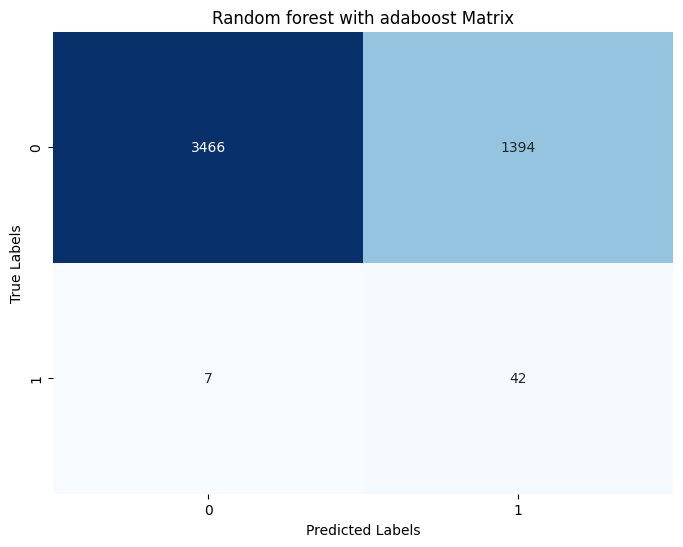

In [603]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random forest with adaboost Matrix")
plt.show()